In [1]:
%load_ext autoreload
%autoreload 2
import os
os.sys.path.insert(0, '/home/ai/Documents/braindecode-master/braindecode')

# Cropped Decoding

Now we will use cropped decoding. Cropped decoding means the ConvNet is trained on time windows/time crops within the trials. Most of the code is identical to the [Trialwise Decoding Tutorial](TrialWise_Decoding.html), differences are explained in the text.

## Load data

In [2]:
import mne
from mne.io import concatenate_raws

# 5,6,7,10,13,14 are codes for executed and imagined hands/feet
subject_id = 19
event_codes = [5,6,9,10,13,14]

# This will download the files if you don't have them yet,
# and then return the paths to the files.
physionet_paths = mne.datasets.eegbci.load_data(subject_id, event_codes)

# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto', verbose='WARNING')
         for path in physionet_paths]

# Concatenate them
raw = concatenate_raws(parts)

# Find the events in this dataset
events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Extract trials, only using EEG channels
epoched = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=eeg_channel_inds,
                baseline=None, preload=True)


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
179 events found
Event IDs: [1 2 3]
90 matching events found
No baseline correction applied
Not setting metadata
Loading data for 90 events and 497 original time points ...
6 bad epochs dropped


## Convert data to Braindecode format

In [3]:
import numpy as np
from braindecode.datautil.signal_target import SignalAndTarget
# Convert data from volt to millivolt
# Pytorch expects float32 for input and int64 for labels.
#print(events[:,1])
#print(events[:,2]-2)
#print(epoched.events[:,2]-2)
X = (epoched.get_data() * 1e6).astype(np.float32)
print(X.shape)
y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
print(y.shape)

#X_train, X_test, y_train, y_test = X[:60],X[60:],y[:60],y[60:]

#print(X_train.shape)
#print(y_train.shape)
data = SignalAndTarget(X , y)
train_set = SignalAndTarget(X[:60], y=y[:60])
test_set = SignalAndTarget(X[60:], y=y[60:])

print(train_set)

(84, 64, 497)
(84,)


## Create the model

For cropped decoding, we now transform the model into a model that outputs a dense time series of predictions.
For this, we manually set the length of the final convolution layer to some length that makes the receptive field of the ConvNet smaller than the number of samples in a trial. Also, we use `to_dense_prediction_model`, which removes the strides in the ConvNet and instead uses dilated convolutions to get a dense output (see [Multi-Scale Context Aggregation by Dilated Convolutions](https://arxiv.org/abs/1511.07122) and our paper [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) Section 2.5.4 for some background on this).

In [4]:
from braindecode1.models.shallow_fbcsp_conv3 import ShallowFBCSPNet
from braindecode1.models.deep5 import Deep4Net

#from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 450

n_classes = 2
print(train_set.X.shape[1])
in_chans = train_set.X.shape[1]
# final_conv_length determines the size of the receptive field of the ConvNet
model =  ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes, input_time_length=input_time_length,stride_before_pool=True,
                        final_conv_length=1).create_network()

to_dense_prediction_model(model)
print(model)
if cuda:
    model.cuda()
    

from torch import optim

optimizer = optim.Adam(model.parameters())

64
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 64), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(25, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop_2): Dropout(p=0.5)
  (conv_2): Conv2d(40, 80, kernel_size=(10, 1), stride=(1, 1), bias=False)
  (bnorm_2): BatchNorm2d(80, eps=1e-05, momentum=0.7, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expression=elu)
  (pool_2): AvgPool2d(kernel_size=(25, 1), stride=(1, 1), padding=0)
  (pool_nonlin_2): Expression(expression=identity)
  (drop_3): Dropout(p=0.5)
  (conv_3): Conv2d(80, 40, kernel_size=(15, 1), stride=(1, 1), dilation=(15, 1), bias=False)
  (bnorm_3): BatchNorm2d(40, eps=1e-05, momentum=

/home/dansy/Documents/braindecode-master/braindecode1/models/shallow_fbcsp_conv3.py:145: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(model.conv_time.weight, gain=1)
/home/dansy/Documents/braindecode-master/braindecode1/models/shallow_fbcsp_conv3.py:148: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(model.conv_time.bias, 0)
/home/dansy/Documents/braindecode-master/braindecode1/models/shallow_fbcsp_conv3.py:150: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(model.conv_spat.weight, gain=1)
/home/dansy/Documents/braindecode-master/braindecode1/models/shallow_fbcsp_conv3.py:154: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(model.bnorm.weight, 1)
/home/dansy/Documents/braindecode-master/braindecode1/models/shallow_fbcsp_conv3.py:155: UserWarning: nn.init.consta

## Create cropped iterator

For extracting crops from the trials, Braindecode provides the  `CropsFromTrialsIterator?` class. This class needs to know the input time length of the inputs you put into the network and the number of predictions that the ConvNet will output per input. You can determine the number of predictions by passing dummy data through the ConvNet: 

In [5]:
from braindecode.torch_ext.util import np_to_var
# determine output size
test_input = np_to_var(np.ones((2, in_chans, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
print(test_input.shape)
out = model(test_input)

n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

torch.Size([2, 64, 450, 1])
135 predictions per input/trial


/home/dansy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [6]:
from braindecode.datautil.iterators import CropsFromTrialsIterator
iterator = CropsFromTrialsIterator(batch_size=64,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

print(iterator.get_batches(train_set, shuffle=False))

<generator object CropsFromTrialsIterator._yield_block_batches at 0x7f76e1e8ee08>


The iterator has the method `get_batches`, which can be used to get randomly shuffled training batches with `shuffle=True` or ordered batches (i.e. first from trial 1, then from trial 2, etc.) with `shuffle=False`. Additionally, Braindecode provides the `compute_preds_per_trial_for_set` method, which accepts predictions from the ordered batches and returns predictions per trial. It removes any overlapping predictions, which occur if the number of predictions per input is not a divisor of the number of samples in a trial.


<div class="alert alert-info">

These methods can also work with trials of different lengths! For different-length trials, set `X` to be a list of 2d-arrays instead of a 3d-array.

</div>

## Training loop

The code below uses both the cropped iterator and the `compute_preds_per_trial_for_set` function to train and evaluate the network.

## K Folds cross validation

In [7]:
from sklearn.model_selection import KFold # import KFold for cross validation
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier

In [8]:
#kf = KFold(n_splits=6) # Define the split - into 3 folds 
kf = KFold(n_splits=5, random_state=7) #evaluate the k fold cross validation
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf.get_n_splits(X)) 
print(kf) 

5
KFold(n_splits=5, random_state=7, shuffle=False)


In [9]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83] TEST: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83] TEST: [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 68 69 70 71 72 73 74 75 

In [10]:
# reshaping the 3D array of the X dataset into a 2D array dataset for predictions 
                                                    #computation usage
Xtrain=X_train[:,:,496:]
Xtrain=np.squeeze(Xtrain)
print(Xtrain.shape)

Xtest=X_test[:,:,496:]
Xtest=np.squeeze(Xtest)
print(Xtest.shape)

print(y_train.shape)

print(len(y_train), len(Xtrain))

(68, 64)
(16, 64)
(68,)
68 68


In [11]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from matplotlib import pyplot as plt

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

df = pd.DataFrame(np.squeeze(X[:,:,496:])) # reshaping the 3D array of the X dataset into a 2D array dataset for predictions 
Xdata =  np_to_var(np.squeeze(X[:,:,496:]))                                                  #computation usage
print(len(df))
# fit a model
#lm = linear_model.LinearRegression()

#model = lm.fit(Xtrain, y_train)
#predictions = lm.predict(Xtest)
#print(Xtrain.shape, y_train.shape, Xtest.shape)

#Kfolds Cross validation
for batch_X, batch_y in iterator.get_batches(train_set, shuffle=False):
    #pass
    for train_index, test_index in kf.split(batch_X):
       # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = batch_X[train_index], batch_X[test_index]
        y_train, y_test = batch_y[train_index], batch_y[test_index]


84


/home/dansy/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
from braindecode.torch_ext.util import np_to_var, var_to_np
import torch.nn.functional as F
from numpy.random import RandomState
import torch as th
from braindecode.experiments.monitors import compute_preds_per_trial_for_set
rng = RandomState((2017,6,30))
accuracy_nb = {"Train": 0, "Test": 0}
accuracy_sum = {"Train": 0, "Test": 0}
accuracyF_nb = {"Train": 0, "Test": 0}
accuracyF_sum = {"Train": 0, "Test": 0}
loss_nb = {"Train": 0, "Test": 0}
loss_sum = {"Train": 0, "Test": 0}
lossF_nb = {"Train": 0, "Test": 0}
lossF_sum = {"Train": 0, "Test": 0}

loss_graph = {"Train": [], "Test": []}
accuracy_graph = {"Train": [], "Test": []}
                  
                  

i_trial_stops = [trial.shape[1] for trial in train_set.X]

for i_epoch in range(100):
    all_acc = []
    print("Epoch {:d}".format(i_epoch))
    fold=0
    for Train_index, Test_index in kf.split(train_set.X):
        fold= fold+1
        training_set = SignalAndTarget(train_set.X[Train_index], y=y[Train_index])
        val_set = SignalAndTarget(train_set.X[Test_index], y=y[Test_index])
        
        # Set model to training mode
        model.train()
        for batch_X, batch_y in iterator.get_batches(training_set, shuffle=False):
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            # Remove gradients of last backward pass from all parameters 
            optimizer.zero_grad()
            outputs = model(net_in)
            # Mean predictions across trial
            # Note that this will give identical gradients to computing
            # a per-prediction loss (at least for the combination of log softmax activation 
            # and negative log likelihood loss which we are using here)
            outputs = th.mean(outputs, dim=2, keepdim=False)
            loss = F.nll_loss(outputs, net_target)
            loss.backward()
            optimizer.step()

        # Print some statistics each epoch
        model.eval()
        print("Fold {:d}".format(fold))
        for setname, dataset in (('Train', training_set),('Test', val_set)):
            
            # Collect all predictions and losses
            all_preds = []
            all_losses = []
            batch_sizes = []
            for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):
                net_in = np_to_var(batch_X)
                if cuda:
                    net_in = net_in.cuda()
                net_target = np_to_var(batch_y)
                if cuda:
                    net_target = net_target.cuda()
                outputs = model(net_in)
                all_preds.append(var_to_np(outputs))
                outputs = th.mean(outputs, dim=2, keepdim=False)
                loss = F.nll_loss(outputs, net_target)
                loss = float(var_to_np(loss))
                all_losses.append(loss)
                batch_sizes.append(len(batch_X))
            # Compute mean per-input loss 
            loss = np.mean(np.array(all_losses) * np.array(batch_sizes) /
                           np.mean(batch_sizes))
            print("{:6s} Loss: {:.5f}".format(setname, loss))
            lossF_nb[setname] += 1
            lossF_sum[setname] += loss
            # Assign the predictions to the trials
            preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                              input_time_length,
                                                              dataset)
            # preds per trial are now trials x classes x timesteps/predictions
            # Now mean across timesteps for each trial to get per-trial predictions
            meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
            predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
            accuracy = np.mean(predicted_labels == dataset.y)
                
            print("{:6s} Accuracy: {:.1f}%".format(
                setname, accuracy * 100))
            accuracyF_nb[setname] += 1
            accuracyF_sum[setname] += accuracy
            
            all_acc.append(accuracy * 100)
    for setname in ("Train", "Test"):
        print("{:6s} Mean fold Accuracy: {:.1f}%".format(
                    setname, accuracyF_sum[setname]*100/accuracyF_nb[setname]))
        accuracy_graph[setname].append(accuracyF_sum[setname]/accuracyF_nb[setname])
        
        print("{:6s} Mean fold Loss: {:.1f}%".format(
                    setname, lossF_sum[setname]/lossF_nb[setname]))
        loss_graph[setname].append(lossF_sum[setname]/lossF_nb[setname])
        
    for setname in ("Train", "Test"):        
        accuracy_nb[setname] += 1
        accuracy_sum[setname] += accuracyF_sum[setname]*100/accuracyF_nb[setname]
        loss_nb[setname] += 1
        loss_sum[setname] += lossF_sum[setname]/lossF_nb[setname]
        
for setname in ("Train", "Test"):
    print("{} Average accuracy: {:.1f}%".format(setname, accuracy_sum[setname]/accuracy_nb[setname]))
    print("{} Average loss: {:.1f}%".format(setname, loss_sum[setname]/loss_nb[setname]))

Epoch 0


/home/dansy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold 1
Train  Loss: 0.79951
Train  Accuracy: 70.8%
Test   Loss: 0.78534
Test   Accuracy: 58.3%
Fold 2
Train  Loss: 0.52587
Train  Accuracy: 75.0%
Test   Loss: 0.54164
Test   Accuracy: 75.0%
Fold 3
Train  Loss: 0.52795
Train  Accuracy: 77.1%
Test   Loss: 0.76520
Test   Accuracy: 41.7%
Fold 4
Train  Loss: 0.41240
Train  Accuracy: 89.6%
Test   Loss: 0.50065
Test   Accuracy: 83.3%
Fold 5
Train  Loss: 0.39791
Train  Accuracy: 87.5%
Test   Loss: 0.40596
Test   Accuracy: 83.3%
Train  Mean fold Accuracy: 80.0%
Train  Mean fold Loss: 0.5%
Test   Mean fold Accuracy: 68.3%
Test   Mean fold Loss: 0.6%
Epoch 1
Fold 1
Train  Loss: 0.33172
Train  Accuracy: 93.8%
Test   Loss: 0.26276
Test   Accuracy: 91.7%
Fold 2
Train  Loss: 0.19389
Train  Accuracy: 97.9%
Test   Loss: 0.26931
Test   Accuracy: 91.7%
Fold 3
Train  Loss: 0.14586
Train  Accuracy: 100.0%
Test   Loss: 0.18078
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.08407
Train  Accuracy: 100.0%
Test   Loss: 0.13205
Test   Accuracy: 100.0%
Fold 5
Trai

Test   Loss: 0.00043
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00043
Train  Accuracy: 100.0%
Test   Loss: 0.00032
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00042
Train  Accuracy: 100.0%
Test   Loss: 0.00027
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 98.5%
Train  Mean fold Loss: 0.1%
Test   Mean fold Accuracy: 97.5%
Test   Mean fold Loss: 0.1%
Epoch 14
Fold 1
Train  Loss: 0.00037
Train  Accuracy: 100.0%
Test   Loss: 0.00062
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00038
Train  Accuracy: 100.0%
Test   Loss: 0.00063
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00050
Train  Accuracy: 100.0%
Test   Loss: 0.00039
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00037
Train  Accuracy: 100.0%
Test   Loss: 0.00023
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00039
Train  Accuracy: 100.0%
Test   Loss: 0.00023
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 98.6%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 97.7%
Test   Mean fold Loss: 0.1%
Epoch 15
Fold 1
Train  

Test   Loss: 0.00014
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.2%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 98.7%
Test   Mean fold Loss: 0.0%
Epoch 27
Fold 1
Train  Loss: 0.00021
Train  Accuracy: 100.0%
Test   Loss: 0.00034
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00021
Train  Accuracy: 100.0%
Test   Loss: 0.00035
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00022
Train  Accuracy: 100.0%
Test   Loss: 0.00019
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00022
Train  Accuracy: 100.0%
Test   Loss: 0.00013
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00024
Train  Accuracy: 100.0%
Test   Loss: 0.00013
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.2%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 98.8%
Test   Mean fold Loss: 0.0%
Epoch 28
Fold 1
Train  Loss: 0.00027
Train  Accuracy: 100.0%
Test   Loss: 0.00041
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00024
Train  Accuracy: 100.0%
Test   Loss: 0.00048
Test   Accuracy: 100.0%
Fold 3
Train  

Test   Loss: 0.00025
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00017
Train  Accuracy: 100.0%
Test   Loss: 0.00035
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00019
Train  Accuracy: 100.0%
Test   Loss: 0.00017
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00017
Train  Accuracy: 100.0%
Test   Loss: 0.00011
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00014
Train  Accuracy: 100.0%
Test   Loss: 0.00009
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.5%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.1%
Test   Mean fold Loss: 0.0%
Epoch 41
Fold 1
Train  Loss: 0.00014
Train  Accuracy: 100.0%
Test   Loss: 0.00021
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00016
Train  Accuracy: 100.0%
Test   Loss: 0.00025
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00018
Train  Accuracy: 100.0%
Test   Loss: 0.00015
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00014
Train  Accuracy: 100.0%
Test   Loss: 0.00009
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00015
Train  Accuracy: 100

Test   Loss: 0.00011
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00011
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00012
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.6%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.4%
Test   Mean fold Loss: 0.0%
Epoch 54
Fold 1
Train  Loss: 0.00012
Train  Accuracy: 100.0%
Test   Loss: 0.00015
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00011
Train  Accuracy: 100.0%
Test   Loss: 0.00020
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00014
Train  Accuracy: 100.0%
Test   Loss: 0.00012
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00010
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00011
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.6%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.4%
Test   Mean fold Loss: 0.0%
Epoch 55
Fold 1
Train  

Test   Loss: 0.00006
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.7%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.5%
Test   Mean fold Loss: 0.0%
Epoch 67
Fold 1
Train  Loss: 0.00008
Train  Accuracy: 100.0%
Test   Loss: 0.00012
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00009
Train  Accuracy: 100.0%
Test   Loss: 0.00013
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00009
Train  Accuracy: 100.0%
Test   Loss: 0.00008
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00008
Train  Accuracy: 100.0%
Test   Loss: 0.00006
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00008
Train  Accuracy: 100.0%
Test   Loss: 0.00006
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.7%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.5%
Test   Mean fold Loss: 0.0%
Epoch 68
Fold 1
Train  Loss: 0.00008
Train  Accuracy: 100.0%
Test   Loss: 0.00011
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00008
Train  Accuracy: 100.0%
Test   Loss: 0.00012
Test   Accuracy: 100.0%
Fold 3
Train  

Test   Loss: 0.00008
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00010
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00007
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00005
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00005
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.7%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.6%
Test   Mean fold Loss: 0.0%
Epoch 81
Fold 1
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00008
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00008
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00006
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00004
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00006
Train  Accuracy: 100

Test   Loss: 0.00005
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00004
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00004
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.8%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.6%
Test   Mean fold Loss: 0.0%
Epoch 94
Fold 1
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00006
Test   Accuracy: 100.0%
Fold 2
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00007
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.00006
Train  Accuracy: 100.0%
Test   Loss: 0.00005
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00004
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.00005
Train  Accuracy: 100.0%
Test   Loss: 0.00004
Test   Accuracy: 100.0%
Train  Mean fold Accuracy: 99.8%
Train  Mean fold Loss: 0.0%
Test   Mean fold Accuracy: 99.6%
Test   Mean fold Loss: 0.0%
Epoch 95
Fold 1
Train  

In [13]:
loss_graph

{'Train': [0.5327260375022889,
  0.34827538281679155,
  0.2380463194878151,
  0.17982731903321109,
  0.14421222130418754,
  0.12042818999131365,
  0.10337676630338787,
  0.09055535036022774,
  0.08056805047187178,
  0.07257911184249678,
  0.06603308111265174,
  0.060573175229365006,
  0.0559528956783022,
  0.05199043491489387,
  0.04855117666942533,
  0.04554161903424756,
  0.04288731071034871,
  0.04052500075251576,
  0.0384110986201497,
  0.03650779797368159,
  0.03478463619297448,
  0.03321723589641889,
  0.03178524574753322,
  0.030473087777560675,
  0.02926527650037315,
  0.028149565514356184,
  0.027116169478783075,
  0.02615563103567443,
  0.02526219046939614,
  0.024427942102774977,
  0.023646957725014222,
  0.02291444306665653,
  0.02222618375222241,
  0.021578415796744486,
  0.020967329559207427,
  0.020390169256380535,
  0.019843914898445145,
  0.01932628374289427,
  0.018835157303916415,
  0.01836841361837287,
  0.017924571665952963,
  0.017501482119076258,
  0.017098080812

In [14]:
accuracy_graph

{'Train': [0.8,
  0.8916666666666668,
  0.9277777777777778,
  0.9458333333333334,
  0.9566666666666667,
  0.9638888888888889,
  0.9690476190476192,
  0.9729166666666668,
  0.9759259259259261,
  0.9783333333333334,
  0.9803030303030303,
  0.9819444444444445,
  0.9833333333333334,
  0.9845238095238096,
  0.9855555555555556,
  0.9864583333333334,
  0.9872549019607844,
  0.987962962962963,
  0.9885964912280703,
  0.9891666666666667,
  0.9896825396825397,
  0.9901515151515152,
  0.9905797101449276,
  0.9909722222222223,
  0.9913333333333334,
  0.9916666666666668,
  0.9919753086419755,
  0.9922619047619049,
  0.992528735632184,
  0.9927777777777779,
  0.9930107526881722,
  0.9932291666666668,
  0.9934343434343436,
  0.9936274509803923,
  0.9938095238095239,
  0.9939814814814816,
  0.9941441441441442,
  0.9942982456140352,
  0.9944444444444446,
  0.9945833333333334,
  0.9947154471544717,
  0.99484126984127,
  0.9949612403100776,
  0.9950757575757576,
  0.9951851851851853,
  0.9952898550724638

100
100


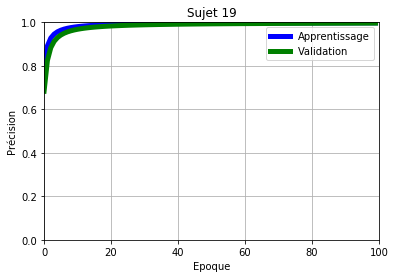

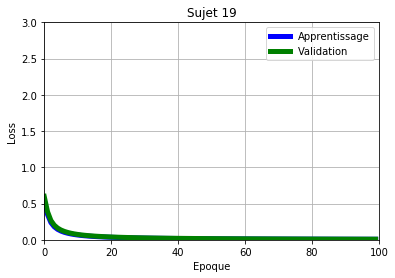

In [15]:
epoch=[]
for val in range(100):
    epoch.append(val)

t = (accuracy_graph['Train']*100)
print(len(accuracy_graph['Train']))
print(len(epoch))

plt.title("Sujet 19")
plt.grid(True)
plt.plot(epoch, accuracy_graph['Train'], "b", linewidth=5, label="Apprentissage")
plt.plot(epoch, accuracy_graph['Test'],"g", linewidth=5, label="Validation")
plt.axis([0, 100, 0, 1])
plt.xlabel('Epoque')
plt.ylabel('Précision')
plt.legend()    
plt.show()

plt.title("Sujet 19")
plt.grid(True)
plt.plot(epoch, loss_graph['Train'], "b", linewidth=5, label="Apprentissage")
plt.plot(epoch, loss_graph['Test'],"g", linewidth=5, label="Validation")
plt.axis([0, 100, 0, 3])
plt.xlabel('Epoque')
plt.ylabel('Loss')
plt.legend()    
plt.show()

In [16]:
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('INFO')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
from sklearn.model_selection import GridSearchCV


# create model
model_net = NeuralNetClassifier(
    module=model,
    max_epochs=20,
    batch_size=64,
    #criterion=th.nn.NLLLoss(np_to_var(batch_X), np_to_var(batch_y), ignore_index=-100, reduce=None),
    lr=0.1,
#     device='cuda',  # uncomment this to train with CUDA
)

model_net.initialize()
#model_net.initialize_module()
#print(model_net)
# fix random seed for reproducibility
seed = 7
# evaluate using 10-fold cross validation stratified cross val
kfold = StratifiedKFold(n_splits=5, random_state=seed)
print(np_to_var(X).size(), np_to_var(y).size() )

for batch_X, batch_y in iterator.get_batches(train_set, shuffle=False):
    pass
    #scores = cross_val_score(model_net, batch_X, batch_y, scoring="accuracy", cv=5)
    
    
#print(batch_X.type())
print(np_to_var(batch_X).type())
print("==================================")
#print(np_to_var(batch_X)[5].size() , np_to_var(batch_y).size())
print("==================================")
#print(np_to_var(batch_X[5]).dim())

param_grid = { 
    'param_1': [1, 2, 3, 4, 5],
    'param_2': [20, 40, 60],
    'param_3': [50, 100, 150]
}


#cv_model = GridSearchCV(estimator=model_net, param_grid=param_grid,scoring="accuracy", cv=5)

#cv_model.fit(np_to_var(batch_X), np_to_var(batch_y))

A=np_to_var(batch_X)
b=np_to_var(batch_y)


from braindecode.torch_ext.optimizers import AdamW
import torch.nn.functional as F
optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
model.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

#scores = cross_val_score(model_net, np_to_var(batch_X[0]), np_to_var(batch_y[0]), scoring="accuracy", cv=5)
#print ("Cross-validated scores:", scores)

torch.Size([84, 64, 497]) torch.Size([84])
torch.FloatTensor


ModuleNotFoundError: No module named 'braindecode.torch_ext.optimizers'

In [ ]:
# Make cross validated predictions
predictions = cross_val_predict(model_net, X, y, cv=6)
plt.scatter(y, predictions)

## Leave one out cross validation 

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)


for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

## Dataset References


 This dataset was created and contributed to PhysioNet by the developers of the [BCI2000](http://www.schalklab.org/research/bci2000) instrumentation system, which they used in making these recordings. The system is described in:
 
     Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE TBME 51(6):1034-1043.

[PhysioBank](https://physionet.org/physiobank/) is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community and further described in:

    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220.